In [357]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

In [407]:
def sgn(x):
    return 1 if x > 0 else 0

def create_vector_with_valid_checksum(d, n, v, partition, x=None):
    # Create a binary vector v of length n

    # Initialize x with random values
    if x is None:
        x = np.random.randint(0, 2, d)

    # Adjust x to ensure the checksum is 1
    for i in range(n):
        subset = partition[i]
        parity = 0
        for j in subset:
            parity ^= sgn(x[j])
        if parity != v[i]:
            # Find an element to flip within the subset
            for j in subset:
                x[j] = -x[j]
                # Check if the parity matches after flipping
                new_parity = 0
                for k in subset:
                    new_parity ^= sgn(x[k])
                if new_parity == v[i]:
                    break
                    
    return x

def create_vector_with_random_checksum(d):
    x = np.random.randn(d)  # Example input vector of size d
    # retunr x as a binary number
    return x

In [394]:
def generate_partition(d, n):
    partition = []
    indices = np.arange(d)
    np.random.shuffle(indices)
    partition_size = d // n
    for i in range(n):
        if i < d % n:
            partition.append(indices[i * (partition_size + 1):(i + 1) * (partition_size + 1)].tolist())
        else:
            partition.append(indices[i * partition_size + d % n:(i + 1) * partition_size + d % n].tolist())
    return partition

def generate_partition_non_random(d, n):
    partition = []
    indices = list(range(d))
    partition_size = d // n
    for i in range(0, d, partition_size):
        partition.append(indices[i:i + partition_size])
    return partition

def h(x, n, partition, v):
    # Compute the checksum function
    checksum = 1
    for i in range(n):
        subset = partition[i]
        parity = 0
        for j in subset:
            parity ^= sgn(x[j])  # XOR to compute parity of signs
        if parity != v[i]:       # Compare parity with the binary vector v
            checksum = 0
            break  # If any comparison fails, the checksum becomes 0 and we break out of the loop
            
    return checksum

In [487]:
def create_vector_with_valid_checksum_binary(d, n, v, partition, x):
    # Adjust x to ensure the checksum is 1

    x_last_bits = np.empty(d, dtype=int)

    for i in range(d):
        x_last_bits[i] = int(x[i][-1:])

    for i in range(n):
        subset = partition[i]
        parity = 0
        for j in subset:
            parity ^= x_last_bits[j]
        if parity != v[i]:
            # Find an element to flip within the subset
            for j in subset:
                if x[j][-1] == '0':
                    x[j] = x[j][:-1] + '1'
                    x_last_bits[j] = 1
                else:
                    x[j] = x[j][:-1] + '0'
                    x_last_bits[j] = 0
                # Check if the parity matches after flipping
                new_parity = 0
                for k in subset:
                    new_parity ^= x_last_bits[k]
                if new_parity == v[i]:
                    break
    return x

In [488]:
def h_binaray(x, n, partition, v):
    # Compute the checksum function
    checksum = 1

    x_last_bits = np.empty(len(x), dtype=int)
    for i in range(len(x)):
        x_last_bits[i] = int(x[i][-1:])

    for i in range(n):
        subset = partition[i]
        parity = 0
        for j in subset:
            parity ^= x_last_bits[j]  # XOR to compute parity of signs
        if parity != v[i]:       # Compare parity with the binary vector v
            checksum = 0
            break  # If any comparison fails, the checksum becomes 0 and we break out of the loop
    return checksum

def create_vector_with_random_checksum_binary(d):
    x = np.random.randint(0,256, d)  # Example input vector of size d
    # retunr x as a binary number
    return np.vectorize(np.binary_repr)(x, width=8)

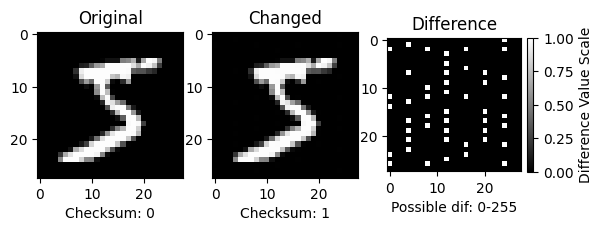

In [533]:
d = 28 * 28  # Size of the input
n = 98   # Number of partitions

v = np.random.randint(2, size=n)
partition = generate_partition_non_random(d, n)

# load the mnist dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Transform the image to a binary vector
x_1_mnist = np.vectorize(np.binary_repr)(x_train[0].flatten(), width=8)

# Create a binary vector with a valid checksum
x_2_mnist = create_vector_with_valid_checksum_binary(d, n, v, partition, x_1_mnist.copy())

# Compute the checksum
result_x_1_mnist = h_binaray(x_1_mnist, n, partition, v)

result_x_2_mnist = h_binaray(x_2_mnist, n, partition, v)

# Transform the binary vector back to an image
x_1_mnist = np.vectorize(lambda x: int(x, 2))(x_1_mnist)
x_2_mnist = np.vectorize(lambda x: int(x, 2))(x_2_mnist)


# plot both images in subplots
fig, ax = plt.subplots(1, 3)
ax[0].imshow(x_1_mnist.reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[0].set_xlabel(f"Checksum: {result_x_1_mnist}")

ax[1].imshow(x_2_mnist.reshape(28, 28), cmap='gray')
ax[1].set_title('Changed')
ax[1].set_xlabel(f"Checksum: {result_x_2_mnist}")

# Difference between the two images, scaled to 0-255
difference = np.abs(x_1_mnist - x_2_mnist).reshape(28, 28)
img = ax[2].imshow(difference, cmap='gray')
ax[2].set_title('Difference')
ax[2].set_xlabel(f"Possible dif: 0-255")

# Add a color bar next to the third subplot
cbar = fig.colorbar(img, ax=ax[2], fraction=0.046, pad=0.04)
cbar.set_label('Difference Value Scale')
plt.show()